In [1]:
import random, os
import numpy as np
import torch

def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything(42)

In [2]:
import datasets
import pandas as pd
from ast import literal_eval

data_dir = '../input/vietnamese-essay-identify/dataset.csv'

df = pd.read_csv(data_dir )

In [3]:
df

,Text,label_id,label_name
0,“Bản lĩnh” – hai từ thật đơn giản nhưng bạn bi...,0,Nghị Luận
1,Giống như một chiếc áo giáp được tôi luyện từ ...,0,Nghị Luận
2,Vậy bản lĩnh là gì? Bản lĩnh là khả năng giải ...,0,Nghị Luận
3,Người bản lĩnh là người dám đương đầu với khó ...,0,Nghị Luận
4,"Thất bại, tự họ sẽ đứng lên",0,Nghị Luận
...,...,...,...
14114,Họ không những mến khách mà còn như một người ...,4,Thuyết minh
14115,Những con người ở đây nồng nhiệt mỗi khi có kh...,4,Thuyết minh
14116,Qua đây ta thấy vịnh Hạ Long rất xứng đáng là ...,4,Thuyết minh
14117,Nếu những ai đã được đặt chân đến đây thì chắc...,4,Thuyết minh


In [4]:
df['label_name'].value_counts()

label_name
Miêu tả        3402
Thuyết minh    2882
Tự sự          2731
Nghị Luận      2593
Biểu cảm       2511
Name: count, dtype: int64

In [5]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size = 0.2)

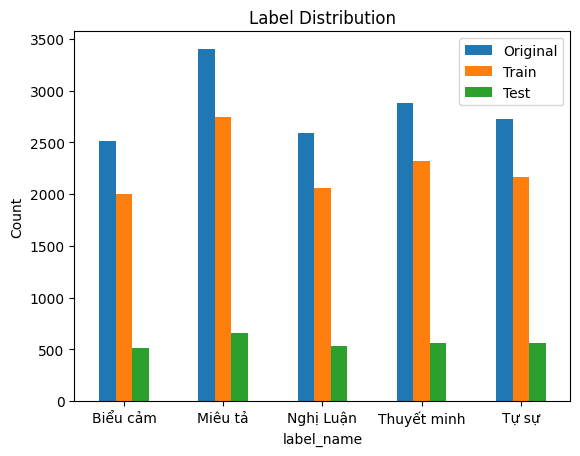

In [6]:

import matplotlib.pyplot as plt
def plot_label_distribution(y_original, y_train, y_test, title):
    counts = pd.DataFrame({
        'Original': y_original.value_counts(),
        'Train': y_train.value_counts(),
        'Test': y_test.value_counts()
    })
    counts.plot(kind='bar', rot=0)
    plt.title(title)
    plt.ylabel('Count')
    plt.show()
y = df['label_name']
y_train = train_df['label_name']
y_test = test_df['label_name']
title = f"Label Distribution"
plot_label_distribution(y, y_train, y_test, title)

In [7]:
import os
import gc
import json
import numpy as np
from scipy import interpolate
from pathlib import Path
import torch
from torch import nn
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def evaluate(true_labels, predicts):
    test_accuracy = accuracy_score(true_labels, predicts)
    test_precision = precision_score(true_labels, predicts, average='macro')
    test_recall = recall_score(true_labels, predicts, average='macro')
    test_f1 = f1_score(true_labels, predicts, average='macro')
    test_cm = confusion_matrix(true_labels, predicts)

    print("Accuracy: {:.4f}".format(test_accuracy))
    print("Precision: {:.4f}".format(test_precision))
    print("Recall: {:.4f}".format(test_recall))
    print("F1-score: {:.4f}".format(test_f1))
    print("Confusion matrix:\n", test_cm)
    print(classification_report(true_labels, predicts, digits=4))
    
    return test_cm


def plotting_confusion_matrix(labels, confusion_matrix, model_name):
    Path(model_name).mkdir(parents=True, exist_ok=True)
    labels = labels
    font_size = 30
        
    plt.figure(dpi=100)
    df_cm = pd.DataFrame(confusion_matrix, index=labels, columns=labels)
    ax = sns.heatmap(df_cm, annot=True, cmap="Greys", fmt="g", cbar=True, annot_kws={"size": font_size})
    
    file_name = os.path.join(model_name, f"{model_name}_confusion_matrix.pdf")
    plt.savefig(file_name, dpi=300, bbox_inches='tight')
    plt.show()

In [8]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [9]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig

from tqdm.notebook import tqdm
from torch import nn

    
class TextClassifier:
    def __init__(self, model_name="essay_identification"):
        self.model_name =model_name
        self.num_labels = 5    
        self._load_model_and_tokenizer(self.model_name)

    def _load_model_and_tokenizer(self, model_name):
       
        self.tokenizer = AutoTokenizer.from_pretrained('PaulTran/vietnamese_essay_identify', use_fast=False)
        self.model = AutoModelForSequenceClassification.from_pretrained('PaulTran/vietnamese_essay_identify', num_labels=5)
        config = AutoConfig.from_pretrained('PaulTran/vietnamese_essay_identify')
        self.id2label = getattr(config, "id2label", {i: str(i) for i in range(self.num_labels)})
       

    def encode_data(self, text):
        return self.tokenizer(text, return_tensors='pt', max_length=512, truncation=True, padding=True)
        
    def classify(self, text, model_name= "essay_identification", num_labels= None, max_length=512):
        """
        Classify the input text and return the predicted label.
        """
        if not text:
            raise ValueError("Input text cannot be empty.")
        if model_name and model_name != self.model_name:
            self.model_name = model_name
            self._load_model_and_tokenizer(self.model_name)

        inputs = self.encode_data(text)
        outputs = self.model(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'] if 'attention_mask' in inputs else None)
        logits = outputs.logits
        predicted_label = logits.argmax(dim=-1).item()
        return predicted_label
    def test(self,data):
         predicts = []
         for text in tqdm(data['Text']):
            inputs = self.encode_data(text)
            outputs = self.model(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'] if 'attention_mask' in inputs else None)
            logits = outputs.logits
            predicted_label = logits.argmax(dim=-1).item()
            predicts.append(predicted_label)
         return data['label_id'], predicts    

In [10]:
import os
import torch
model_name="essay_identification"
model = TextClassifier()
true_labels, predicts = model.test(test_df)
test_cm = evaluate(true_labels, predicts)

tokenizer_config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/17.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

2025-07-08 09:54:29.907481: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751968470.094601      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751968470.146516      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

  0%|          | 0/2824 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/540M [00:00<?, ?B/s]

Accuracy: 0.8672
Precision: 0.8690
Recall: 0.8692
F1-score: 0.8673
Confusion matrix:
 [[467  21   6  15  22]
 [ 16 442  17  20  15]
 [ 11  71 534  14  27]
 [  7  40  10 505   2]
 [ 22  25   9   5 501]]
              precision    recall  f1-score   support

           0     0.8929    0.8795    0.8861       531
           1     0.7379    0.8667    0.7971       510
           2     0.9271    0.8128    0.8662       657
           3     0.9034    0.8954    0.8994       564
           4     0.8836    0.8915    0.8875       562

    accuracy                         0.8672      2824
   macro avg     0.8690    0.8692    0.8673      2824
weighted avg     0.8731    0.8672    0.8683      2824



In [11]:
labels = [model.id2label[i] for i in range(0,5)]
print(labels)

['Nghị luận', 'Biểu cảm', 'Miêu tả', 'Tự sự', 'Thuyết minh']


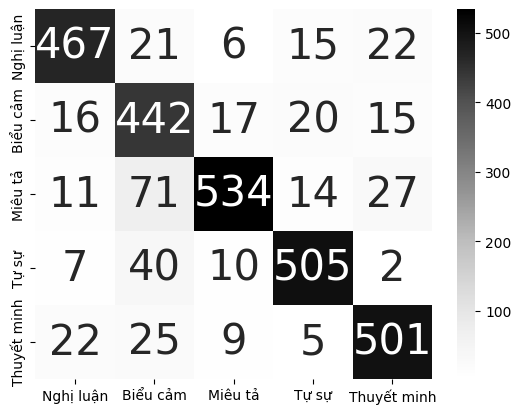

In [12]:
plotting_confusion_matrix(labels, test_cm, model_name)

In [13]:
import os
import pandas as pd

predict_df = pd.DataFrame({'Text': test_df['Text'],
                           'true_label': true_labels, 'predict': predicts})
predict_df.to_csv(os.path.join(model_name, f'{model_name}_test_prediction.csv'), index=False)
wrong_df = predict_df[predict_df.true_label != predict_df.predict]
sorted_df = wrong_df.sort_values(['true_label', 'predict'], ascending=[False, False])
sorted_df

,Text,true_label,predict
12843,Nó đồng hành với tôi mỗi ngày,4,3
11454,"Anh ơi, nếm thử mà xem,",4,3
12433,Ông bà ta sợ nhất cảnh này vì mấy tháng trông ...,4,3
13880,Chẳng phải họ văn vẻ gì đâu,4,3
11431,"Bất chợt mẹ tôi bảo: ""Hôm nay, trời lạnh con m...",4,3
...,...,...,...
2058,Nhờ có cái “dại” ta mới biết được mình “dại” v...,0,1
668,"Nó phải chứa đựng một cái gì đó lớn lao, mạnh ...",0,1
1047,Thanh niên ngày nay không chỉ vùi đầu vào sách...,0,1
1670,"Nhưng khi biết sẻ chia, bầu trời hạnh phúc sẽ ...",0,1
